In [1]:
%matplotlib inline

import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt
import numpy as np
import tifffile as tif
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from skimage.io import imread
from utils import normalize_volume  # from 'https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/utils.py' for compatibility with pretrained model


/home/dhhyun/env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/dhhyun/env/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/dhhyun/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def open_input(path, show=False):
    image = imread(path)
    if show:
        plt.imshow(image)
    image = normalize_volume(image)
    image = np.asarray(image, dtype='float32')


    tensor = np.transpose(image, (2, 0, 1))
    tensor = np.ascontiguousarray(tensor)
    tensor_batch = np.expand_dims(tensor, axis=0)

    return tensor_batch


(1, 3, 256, 256)


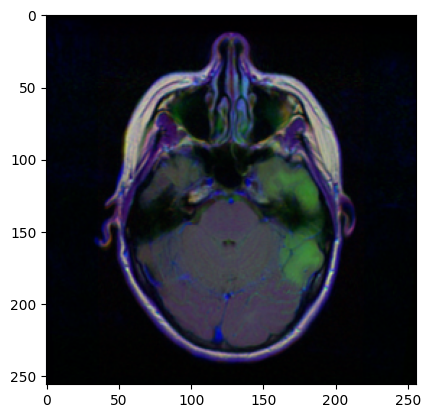

In [3]:
input = open_input('data/image1.tif', True)
print(input.shape)

In [4]:
with open('unet_fp16.engine', 'rb') as f:
    runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))

    engine = runtime.deserialize_cuda_engine(f.read())
    context = engine.create_execution_context()

output data type: float32
output shape: (1, 1, 256, 256)


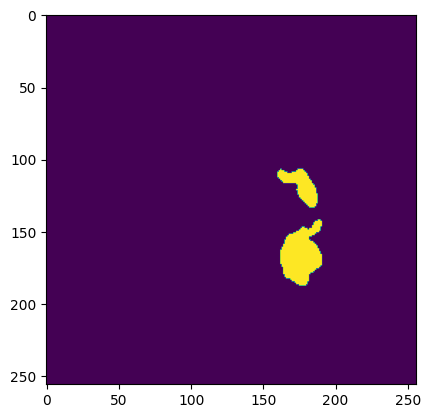

In [5]:
output_fp16 = np.zeros((1, 1, 256, 256), dtype=np.float32)

d_output = cuda.mem_alloc(output_fp16.nbytes)
d_input = cuda.mem_alloc(input.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()

cuda.memcpy_htod_async(d_input, input, stream)
context.execute_async_v2(bindings, stream.handle, None)
cuda.memcpy_dtoh_async(output_fp16, d_output, stream)
stream.synchronize()

print(f'output data type: {output_fp16.dtype}')
print(f'output shape: {output_fp16.shape}')
output_fp16 = torch.from_numpy(output_fp16)
output_fp16 = output_fp16.squeeze(0).squeeze(0).gt(0.5)
plt.imshow(output_fp16)

In [6]:
%%timeit -n 1000 -r 10

output = np.zeros((1, 1, 256, 256), dtype=np.float32)

d_output = cuda.mem_alloc(output.nbytes)
d_input = cuda.mem_alloc(input.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()


cuda.memcpy_htod_async(d_input, input, stream)
context.execute_async_v2(bindings, stream.handle, None)
cuda.memcpy_dtoh_async(output, d_output, stream)
stream.synchronize()


2.15 ms ± 43.6 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [7]:
with open('unet_int8.engine', 'rb') as f:
    runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))

    engine = runtime.deserialize_cuda_engine(f.read())
    context = engine.create_execution_context()

output data type: float32
output shape: (1, 1, 256, 256)


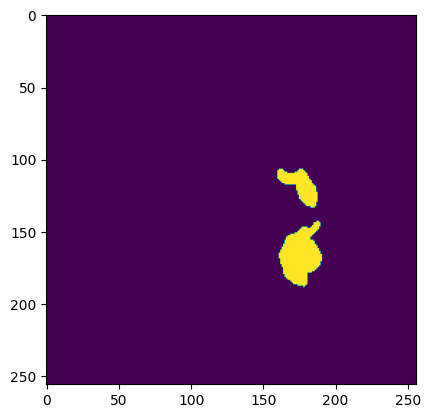

In [8]:
output_int8 = np.zeros((1, 1, 256, 256), dtype=np.float32)

d_output = cuda.mem_alloc(output_int8.nbytes)
d_input = cuda.mem_alloc(input.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()

cuda.memcpy_htod_async(d_input, input, stream)
context.execute_async_v2(bindings, stream.handle, None)
cuda.memcpy_dtoh_async(output_int8, d_output, stream)
stream.synchronize()

print(f'output data type: {output_int8.dtype}')
print(f'output shape: {output_int8.shape}')
output_int8 = torch.from_numpy(output_int8)
output_int8 = output_int8.squeeze(0).squeeze(0).gt(0.5)
plt.imshow(output_int8)

In [9]:
%%timeit -n 1000 -r 10

output = np.zeros((1, 1, 256, 256), dtype=np.float32)

d_output = cuda.mem_alloc(output.nbytes)
d_input = cuda.mem_alloc(input.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()

cuda.memcpy_htod_async(d_input, input, stream)
context.execute_async_v2(bindings, stream.handle, None)
cuda.memcpy_dtoh_async(output, d_output, stream)
stream.synchronize()


1.75 ms ± 5.21 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [10]:
_input = open_input('data/image1.tif')

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                       in_channels=3, out_channels=1, init_features=32, pretrained=True).to('cuda')
model.eval()

Using cache found in /home/dhhyun/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

output shape: torch.Size([1, 1, 256, 256])
output dtype: torch.float32
torch.Size([256, 256])


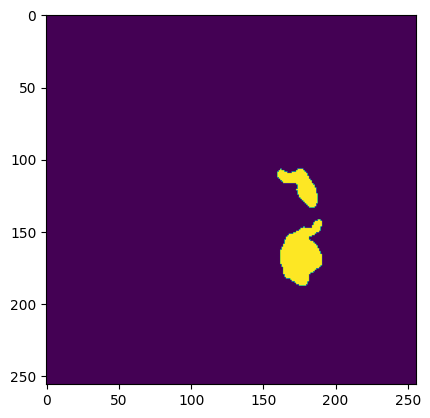

In [11]:
input = torch.from_numpy(_input).to('cuda')
with torch.no_grad():
    output_baseline = model(input)

print(f'output shape: {output_baseline.shape}')
print(f'output dtype: {output_baseline.dtype}')
output_baseline = output_baseline.to('cpu').squeeze(0).squeeze(0).gt(0.5)
print(output_baseline.shape)


plt.imshow(output_baseline)

In [12]:
%%timeit -n 1000 -r 10
input = torch.from_numpy(_input).to('cuda')
with torch.no_grad():
    _out = model(input)

out = _out.to('cpu')

8.16 ms ± 43.8 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [13]:
def pixel_error(pred, ground):
    wrong = torch.logical_xor(pred, ground)
    plt.imshow(wrong)
    wrong = wrong.sum()
    M = ground.shape[0] * ground.shape[1]

    return wrong / M

def wrapping_error(pred, ground):
    

SyntaxError: unexpected EOF while parsing (3348390748.py, line 10)

int8 error: 0.001312255859375


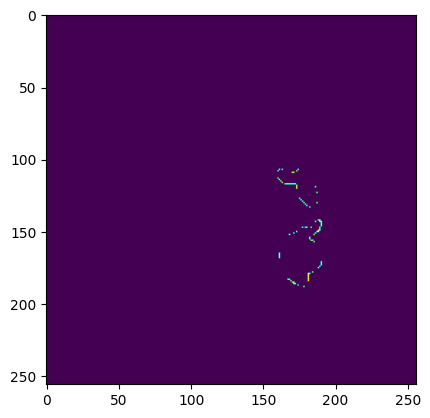

In [ ]:
err_int8 = pixel_error(output_int8, output_baseline)
print(f'int8 error: {err_int8}')


fp16 error: 3.0517578125e-05


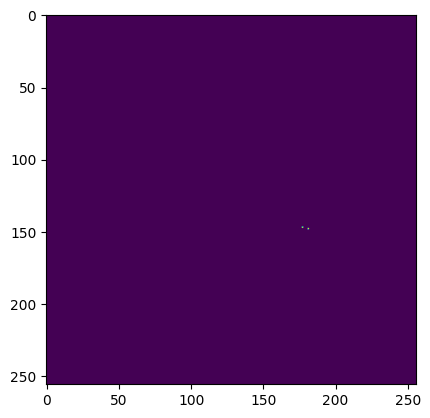

In [34]:

err_fp16 = pixel_error(output_fp16, output_baseline)
print(f'fp16 error: {err_fp16}')